In [168]:
# Find quotes about difficulty of writing descriptions
# Mention statistics 

%matplotlib inline
import pandas as pd
import re
import codecs

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('brown')

from functools import reduce
# from jupyterthemes import jtplot

# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
# jtplot.style(theme='chesterish')

def neatify_headers(df):
    old_col_headers = list(df)
    new_col_headers = [och.replace(' ', '') for och in old_col_headers]
    rename_headers_map = {och: nch for och, nch in zip(old_col_headers, new_col_headers)}
    return df.rename(columns=rename_headers_map)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/skunche/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/skunche/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /Users/skunche/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [169]:
# 'preschool_prek', 
filenames = ('k_2', '3_5', '6_8', '9_12')
dfs = []
for grade_category, filename in enumerate(filenames):
    df = pd.read_csv("cal_dept_of_edu/{}.csv".format(filename))
    df = neatify_headers(df)
    df['GradeCategory'] = grade_category
    dfs.append(df)
df = reduce(lambda a, b: a.append(b), dfs)

In [170]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

standardize_text(df, "Annotation")

,TitleID,Title,Annotation,Publisher,Copyright,OriginalCopyright,Translator,Author,Illustrator,GradeLevelSpan,Language,Genre,Classification,Culture,Topic,Discipline,Standard,Award,GradeCategory
0,39313,"""Let's Get a Pup!"" Said Kate",when kate and her parents visit the animal she...,Candlewick Press,2001,NaN,NaN,Bob Graham,Bob Graham,K thru 2,English,Realistic Fiction,Picture Book,NaN,English-Language Arts/General,English-Language Arts/Literary Elements,NaN,NaN,0
1,16516,"""Slowly, Slowly, Slowly,"" Said the Sloth",a day in the life of a sloth is also a message...,Philomel Books,2002,NaN,NaN,Eric Carle,Eric Carle,K thru 2,English,Fiction,Picture Book,NaN,Life Science (Biology),Science,LS K.2,NaN,0
2,37332,'Twas the Night Before Thanksgiving,schoolchildren on a thanksgiving field trip to...,Orchard Books,1991,NaN,NaN,Dav Pilkey,Dav Pilkey,K thru 2,English,Fiction,Picture Book,NaN,English-Language Arts/General,"English-Language Arts/Vocabulary, English-Lang...",NaN,NaN,0
3,38510,"¡Cuidado, pajarito! (Look Out, Bird!)",things in the animal world are never quite the...,Ediciones Norte-Sur,1997,NaN,Alis Alejandro,Marilyn Janovitz,Marilyn Janovitz,K thru 2,Spanish,Fiction,Picture Book,NaN,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0
4,38511,¡Hola abuelos! (Hello Grandparents!),this story highlights the special bond shared ...,Buenos Aires: Editorial Planeta Argentina,1999,NaN,NaN,Margarita Maine,Nora Hilb,K thru 2,Spanish,Fiction,"Easy Reader, Picture Book",Latino/Latino American,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0
5,38512,¡La senorita Nelson ha desaparecido! (Miss Nel...,"when miss nelson's class misbehaves, she disap...",Houghton Mifflin,1998,NaN,Yanitzia Canetti,Harry Allard,James Marshall,"K thru 2, 3 thru 5",Spanish,Fiction,"Picture Book, Read Aloud",NaN,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0
6,38513,¡Me gusto como soy! (I Like Me!),she's a pig with confidence and a mind of her ...,Viking Press,1997,NaN,NaN,Nancy Carlson,Nancy Carlson,K thru 2,Spanish,Fiction,Picture Book,NaN,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0
7,38514,"¡No, Tito, no! (No, No, Titus!)",when tito moves to the farm with his new famil...,North-South Books,1999,NaN,Diego Lasconi,Claire Masurel,Claire Masurel,K thru 2,Spanish,Fiction,"Easy Reader, Picture Book",NaN,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0
8,38515,¡Papa! (Father!),"""father!"" they cry out in unison a young boy ...",Barcelona: Editorial Corimbo,1999,NaN,Anna Coll-Vinent,Philippe Corentin,Philippe Corentin,K thru 2,Spanish,Fiction,"Easy Reader, Picture Book",NaN,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0
9,38516,¡Que monton de tamales! (Too Many Tamales),the importance of honesty is shown as four lat...,Putnam Publishing,1996,NaN,Alma Flor Ada,Gary Soto,Ed Martinez,"K thru 2, 3 thru 5",Spanish,"Fiction, Realistic Fiction","Easy Reader, Picture Book, Read Aloud",Latino/Latino American,English-Language Arts/General,"History/Social Science, English-Language Arts/...","HSS K.3, HSS 1.4",NaN,0


In [171]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

df["tokens"] = df["Annotation"].apply(tokenizer.tokenize)
df.head()

,TitleID,Title,Annotation,Publisher,Copyright,OriginalCopyright,Translator,Author,Illustrator,GradeLevelSpan,Language,Genre,Classification,Culture,Topic,Discipline,Standard,Award,GradeCategory,tokens
0,39313,"""Let's Get a Pup!"" Said Kate",when kate and her parents visit the animal she...,Candlewick Press,2001,NaN,NaN,Bob Graham,Bob Graham,K thru 2,English,Realistic Fiction,Picture Book,NaN,English-Language Arts/General,English-Language Arts/Literary Elements,NaN,NaN,0,"[when, kate, and, her, parents, visit, the, an..."
1,16516,"""Slowly, Slowly, Slowly,"" Said the Sloth",a day in the life of a sloth is also a message...,Philomel Books,2002,NaN,NaN,Eric Carle,Eric Carle,K thru 2,English,Fiction,Picture Book,NaN,Life Science (Biology),Science,LS K.2,NaN,0,"[a, day, in, the, life, of, a, sloth, is, also..."
2,37332,'Twas the Night Before Thanksgiving,schoolchildren on a thanksgiving field trip to...,Orchard Books,1991,NaN,NaN,Dav Pilkey,Dav Pilkey,K thru 2,English,Fiction,Picture Book,NaN,English-Language Arts/General,"English-Language Arts/Vocabulary, English-Lang...",NaN,NaN,0,"[schoolchildren, on, a, thanksgiving, field, t..."
3,38510,"¡Cuidado, pajarito! (Look Out, Bird!)",things in the animal world are never quite the...,Ediciones Norte-Sur,1997,NaN,Alis Alejandro,Marilyn Janovitz,Marilyn Janovitz,K thru 2,Spanish,Fiction,Picture Book,NaN,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0,"[things, in, the, animal, world, are, never, q..."
4,38511,¡Hola abuelos! (Hello Grandparents!),this story highlights the special bond shared ...,Buenos Aires: Editorial Planeta Argentina,1999,NaN,NaN,Margarita Maine,Nora Hilb,K thru 2,Spanish,Fiction,"Easy Reader, Picture Book",Latino/Latino American,English-Language Arts/General,English-Language Arts/General,NaN,NaN,0,"[this, story, highlights, the, special, bond, ..."


In [172]:
import re
import string
regex = re.compile('[%s]' % re.escape(string.punctuation)) #see documentation here: http://docs.python.org/2/library/string.html
df['no_punctuation_tokens'] = df['tokens'].apply(lambda tkns: [regex.sub(u'', tkn) for tkn in tkns])

In [173]:
from nltk.corpus import stopwords
stopword_set = set(stopwords.words('english'))
df['no_stop_tokens'] = df['no_punctuation_tokens'].apply(lambda tkns: list(filter(lambda tkn: tkn not in stopword_set, tkns)))

In [174]:
df['standarized_annotation'] = df['no_stop_tokens'].apply(" ".join)

Text(0,0.5,'Number of Books')

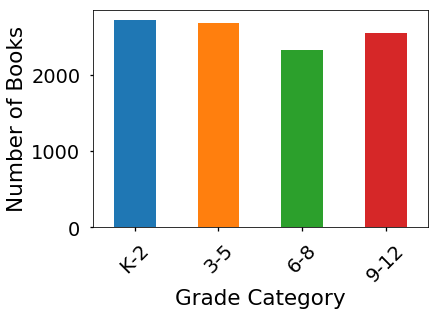

In [175]:
import seaborn as sns
sns.set_context("talk", font_scale=1.5)
ax = df.groupby(['GradeCategory']).count()['TitleID'].plot.bar()
# Consider stratified splitting. Mention alternative of downsampling
# 'Preschool/\nPre-K',
ax.set_xticklabels(['K-2','3-5', '6-8', '9-12'], rotation=45)
ax.set_xlabel('Grade Category')
ax.set_ylabel('Number of Books')

In [176]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in df["no_stop_tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["no_stop_tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

345608 words total, with a vocabulary size of 23541
Max sentence length is 99


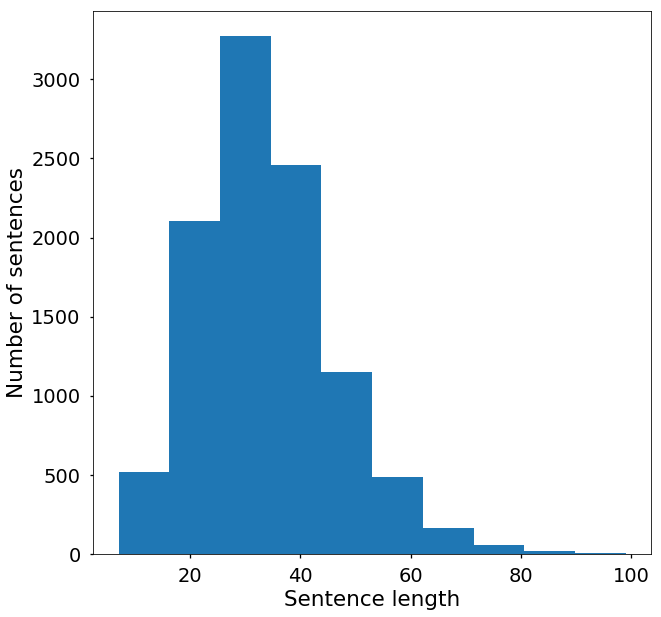

In [177]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

### First, let's try a Bag of Words Counts approach

In [178]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

list_corpus = df["standarized_annotation"].tolist()
list_labels = df["GradeCategory"].tolist()

counts, count_vectorizer = cv(list_corpus)

X_train_counts, X_test_counts, y_train_counts, y_test_counts = train_test_split(counts, list_labels, test_size=0.2, 
                                                                                random_state=40)

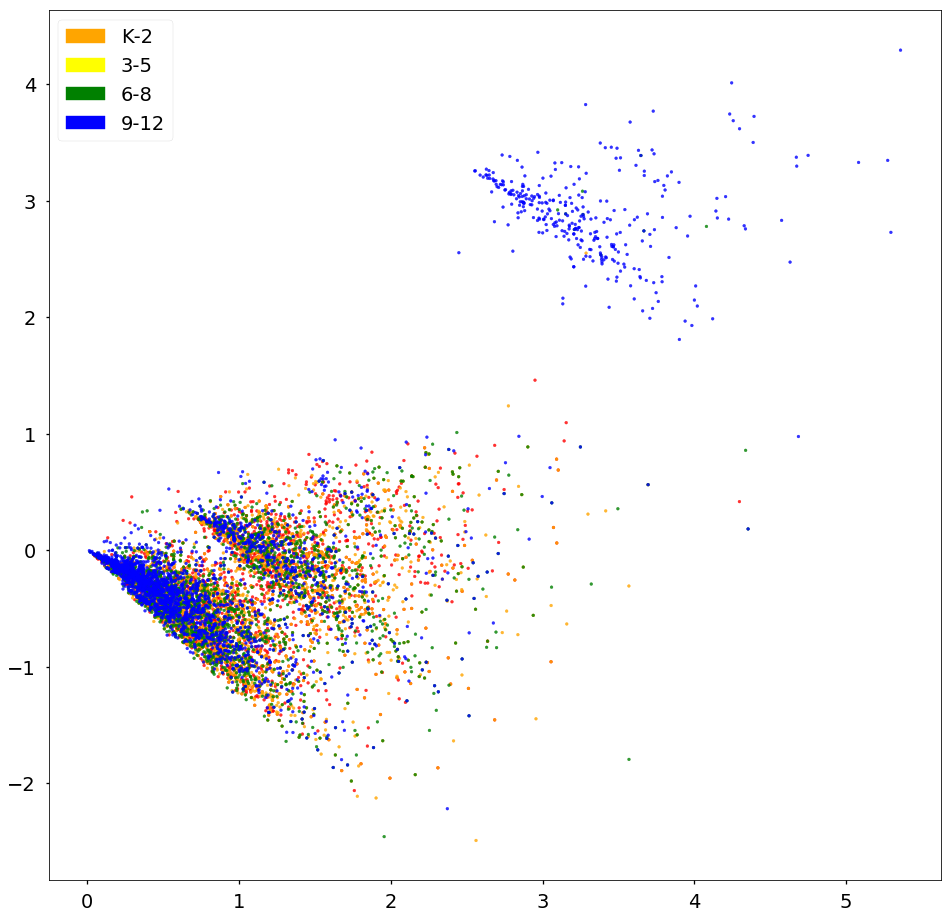

In [179]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['red', 'orange', 'yellow', 'green', 'blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='K-2')
            yellow_patch = mpatches.Patch(color='yellow', label='3-5')
            green_patch = mpatches.Patch(color='green', label='6-8')
            blue_patch = mpatches.Patch(color='blue', label='9-12')
            plt.legend(handles=[orange_patch, yellow_patch, green_patch, blue_patch])


fig = plt.figure(figsize=(16, 16))          
plot_LSA(counts, list_labels)
plt.show()

In [180]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train_counts)

y_predicted_counts = clf.predict(X_test_counts)

In [181]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test_counts, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.432, precision = 0.437, recall = 0.432, f1 = 0.434


In [182]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

Normalized confusion matrix


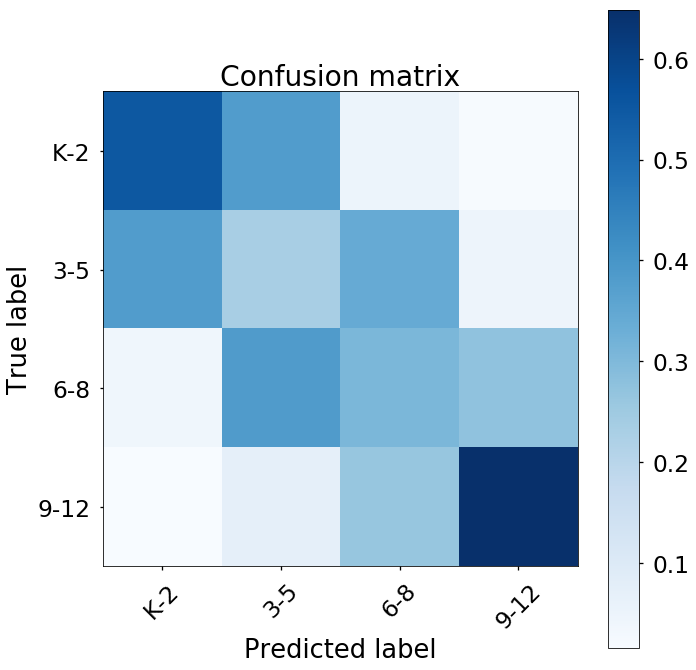

[[289 199  26  10]
 [204 124 182  25]
 [ 18 181 145 129]
 [  8  37 137 336]]


In [43]:
cm = confusion_matrix(y_test_counts, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['K-2','3-5', '6-8', '9-12'], normalize=True, title='Confusion matrix')
plt.show()
print(cm)

In [183]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottoms':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

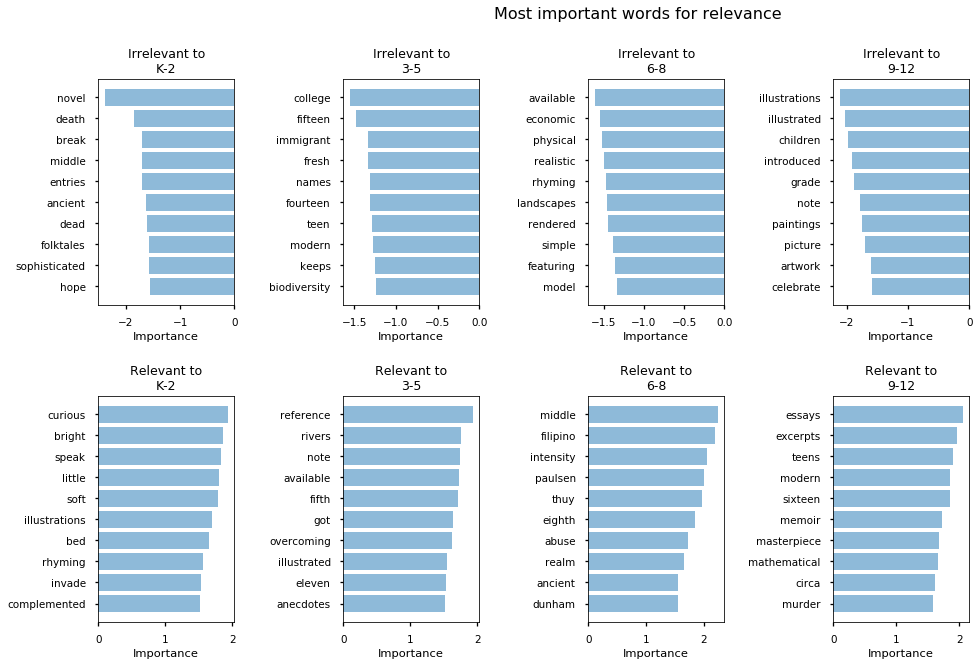

In [184]:
def plot_important_words(importance, name, keys=('bottoms', 'tops',)):
    fig = plt.figure(figsize=(20, 10))
    grade_categories = ('K-2','3-5', '6-8', '9-12')
    for idx, grade_category in enumerate(grade_categories):
        
        top_scores = [a[0] for a in importance[idx][keys[1]]]
        top_words = [a[1] for a in importance[idx][keys[1]]]
        bottom_scores = [a[0] for a in importance[idx][keys[0]]]
        bottom_words = [a[1] for a in importance[idx][keys[0]]]
        
        y_pos = np.arange(len(top_words))
        
        plt.subplot(2, 5, 1 + idx)
        plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
        plt.title('Irrelevant to\n{}'.format(grade_category))
        plt.yticks(y_pos, bottom_words)
        plt.suptitle('Key words', fontsize=16)
        plt.xlabel('Importance')

        plt.subplot(2, 5, 6 + idx)
        plt.barh(y_pos,top_scores, align='center', alpha=0.5)
        plt.title('Relevant to\n{}'.format(grade_category))
        plt.yticks(y_pos, top_words)
        plt.suptitle(name, fontsize=16)
        plt.xlabel('Importance')
    
    plt.subplots_adjust(wspace=0.8, hspace=0.4)
    plt.show()
    
sns.set_context("talk", font_scale=0.8)
plot_important_words(importance, "Most important words for relevance")
sns.set_context("talk", font_scale=1.5)

### TFIDF Bag of Words approach

In [185]:
# Max and min thresholds for tfidf. Maybe remove words that are only specific to a single book
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

tfidfs, tfidf_vectorizer = tfidf(list_corpus)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidfs, list_labels, test_size=0.2, 
                                                                            random_state=40)

In [186]:
import pickle
pickle_output = open("tfidf_vectorizer.pickle","wb")
pickle.dump(tfidf_vectorizer, pickle_output, pickle.HIGHEST_PROTOCOL)
pickle_output.close()

with open("tfidf_vectorizer.pickle", "rb") as tfidf_vectorizer_file:
    tfidf_vectorizer_data = tfidf_vectorizer_file.read()
    tfidf_vectorizer = pickle.loads(tfidf_vectorizer_data)
tfidf_vectorizer_file.closed

True

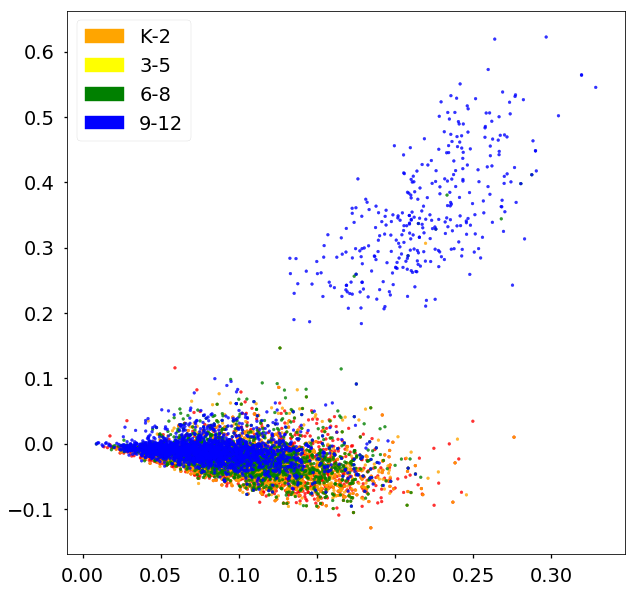

In [187]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(tfidfs, list_labels)
plt.show()

In [188]:
clf_tfidf = LogisticRegression(C=0.3341, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train_tfidf)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [189]:
import pickle
pickle_output = open("clf_tfidf.pickle","wb")
pickle.dump(clf_tfidf, pickle_output, pickle.HIGHEST_PROTOCOL)
pickle_output.close()

with open("clf_tfidf.pickle", "rb") as clf_tfidf_file:
    clf_tfidf_data = clf_tfidf_file.read()
    clf_tfidf = pickle.loads(clf_tfidf_data)
clf_tfidf_file.closed

True

In [190]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test_tfidf, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.536, precision = 0.520, recall = 0.536, f1 = 0.526


Normalized confusion matrix


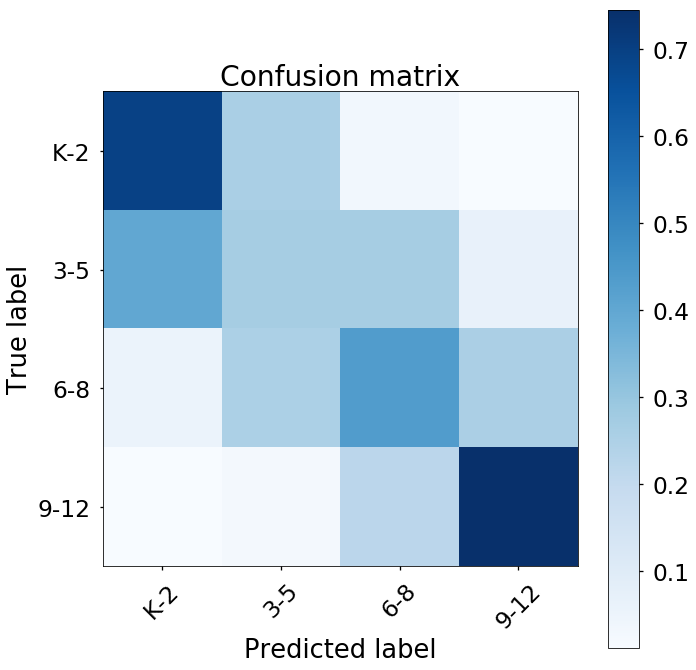

TFIDF confusion matrix
[[364 136  18   6]
 [214 144 143  34]
 [ 27 120 205 121]
 [  6  13 113 386]]
BoW confusion matrix
[[289 199  26  10]
 [204 124 182  25]
 [ 18 181 145 129]
 [  8  37 137 336]]


In [191]:
cm2 = confusion_matrix(y_test_tfidf, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
# 'Preschool/\nPre-K',
grade_categories = ('K-2','3-5', '6-8', '9-12')
sns.set_context("talk", font_scale=1.8)
plot = plot_confusion_matrix(cm2, classes=grade_categories, normalize=True, title='Confusion matrix')
plot.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

[[0.69465649 0.25954198 0.03435115 0.01145038]
 [0.4        0.26915888 0.26728972 0.0635514 ]
 [0.05708245 0.25369979 0.43340381 0.25581395]
 [0.01158301 0.02509653 0.21814672 0.74517375]]
Normalized confusion matrix


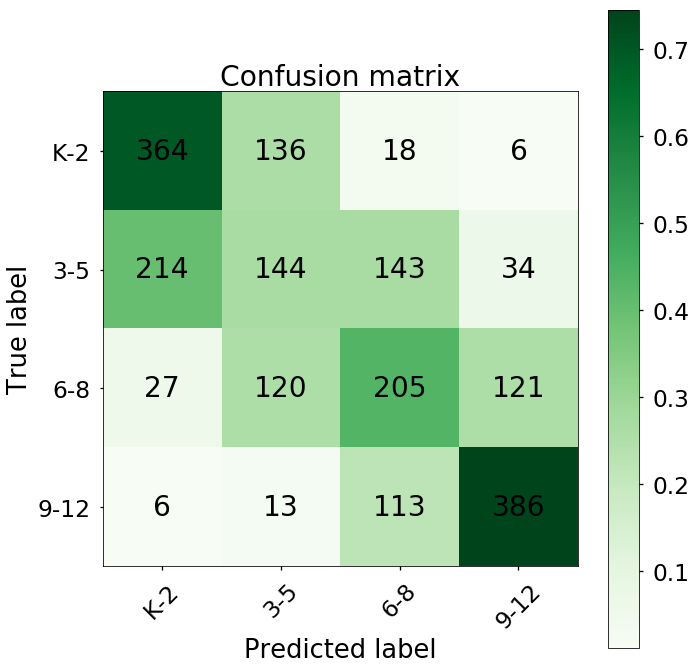

In [192]:
def plot_confusion_matrix_with_labels(cm, classes,
                                      normalize=False,
                                      title='Confusion matrix',
                                      cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print(cm)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
for (j,i),label in np.ndenumerate(cm2):
    ax.text(i,j,label,ha='center',va='center')
sns.set_context("talk", font_scale=1.8)
plot = plot_confusion_matrix_with_labels(cm2, classes=grade_categories, normalize=True, cmap=plt.cm.Greens)
plot.show()

In [193]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

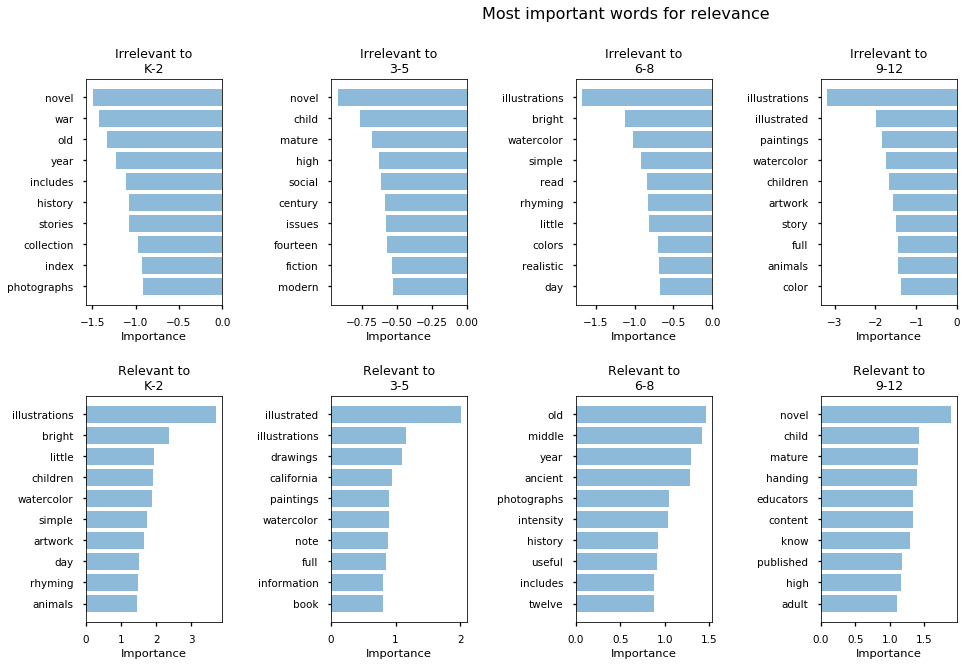

In [194]:
sns.set_context("talk", font_scale=0.8)
plot_important_words(importance_tfidf, "Most important words for relevance")
sns.set_context("talk", font_scale=1.5)

In [195]:
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
c = make_pipeline(tfidf_vectorizer, clf_tfidf)
grade_categories = ('K-2','3-5', '6-8', '9-12')
explainer = LimeTextExplainer(class_names=grade_categories)
exp = explainer.explain_instance(list_corpus[2], c.predict_proba, num_features=6, labels=[0, 1, 2, 3])
exp.show_in_notebook(text=True)

/anaconda3/envs/insight/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


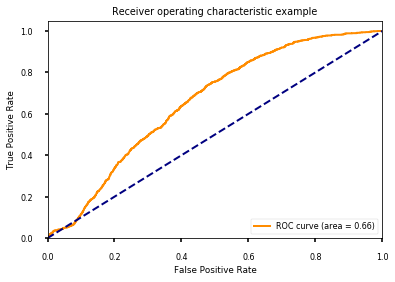

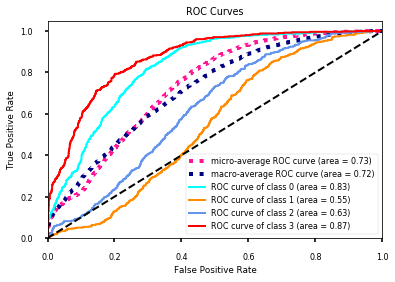

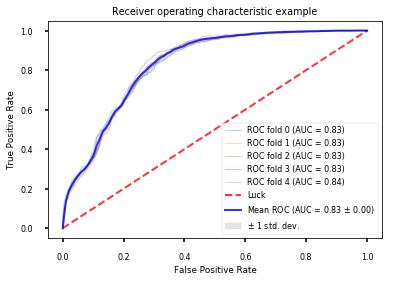